### M5 - Forecasting - Accuracy

### Author: Syed Zain Raza


In [1]:
#import required libraries


import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import gc
import numpy as np, pandas as pd
import lightgbm as lgb
from itertools import cycle
from  datetime import datetime, timedelta
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
# Reading data

calendar_Dates = pd.read_csv('forecast_walmart_data/calendar.csv')
sales_TrainVal = pd.read_csv('forecast_walmart_data/sales_train_validation.csv')
sample_Sub = pd.read_csv('forecast_walmart_data/sample_submission.csv')
selling_P = pd.read_csv('forecast_walmart_data/sell_prices.csv')

In [3]:
#calendar information with dates given by weekday, month and year

calendar_Dates.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [4]:
#sales training validation data which contains item id's, categories, store id's and how many sold at each day

sales_TrainVal.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  ...  d_1889  d_1890  d_1891  \
0     0     0     0     0     0     0     0  ...       0       0       0   
1     0     0     0     0     0     0     0  ...       0       0       0   
2     0     0     0     0     0     0     0  ...       0       0       0   
3     0     0     0     0     0     0     0  ...       0       3       1   
4     0     0     0     0     0     0     0  ...       4       0       1   

   d_1892  d_1893  d_1894  d_1895  d_1896  d_1897  d_1898  d_1899  d_1900  \
0       1       0       4       2       3       0       1       2       0   
1       0       0       0       0       0       0       0       0       0   
2       1       0       0       0       1       0       0       0       0   
3       2       1       3       1       0       2       5       4       2   
4       4       0       1       0       1       0       1       1       2   

   d_1901  d_1902  d_1903  d_1904  d_1905  d_1906  d_1907  d_1908  d_1909  \
0       0       0       1       1       3       0       1       1       1   
1       0       0       0       0       0       0       0       0       1   
2       0       1       2       2       1       2       1       1       1   
3       0       3       0       1       0       5       4       1       0   
4       0       1       1       2       1       1       0       1       1   

   d_1910  d_1911  d_1912  d_1913  
0       3       0       1       1  
1       0       0       0       0  
2       0       1       1       1  
3       1       3       7       2  
4       2       2       2       4  

[5 rows x 1919 columns]

In [5]:
#sample submission in which we have to forecast for the next 28 days

sample_Sub.head()

id  F1  F2  F3  F4  F5  F6  F7  F8  F9  F10  \
0  HOBBIES_1_001_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
1  HOBBIES_1_002_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
2  HOBBIES_1_003_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
3  HOBBIES_1_004_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
4  HOBBIES_1_005_CA_1_validation   0   0   0   0   0   0   0   0   0    0   

   F11  F12  F13  F14  F15  F16  F17  F18  F19  F20  F21  F22  F23  F24  F25  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   F26  F27  F28  
0    0    0    0  
1    0    0    0  
2    0    0    0  
3    0    0    0  
4    0    0    0

In [6]:
selling_P.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

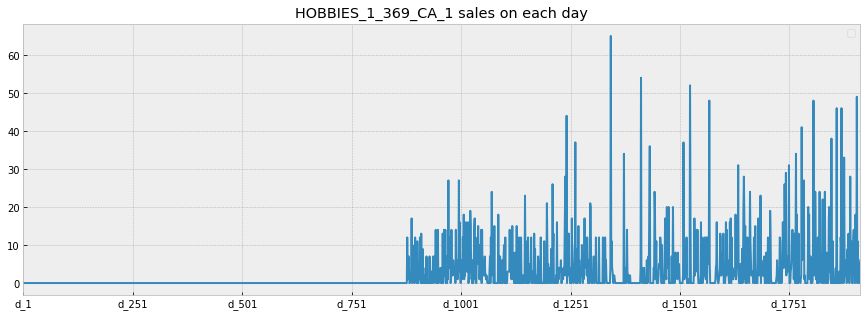

In [7]:
# Let us visualize data for one item

#get all the dates columns in sales data
d_cols = [c for c in sales_TrainVal.columns if 'd_' in c] # sales data columns

#Plotting data for item id 'HOBBIES_1_369' for all days
sales_TrainVal.loc[sales_TrainVal['id'] == 'HOBBIES_1_369_CA_1_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='HOBBIES_1_369_CA_1 sales on each day',
          color=next(color_cycle))
plt.legend('')
plt.show()

# We can see that for few days, line is flat which means that this item was not sold on these days

In [8]:
sales_TrainVal.loc[sales_TrainVal['id'] == 'FOODS_3_090_CA_3_validation']

id      item_id  dept_id cat_id store_id  \
8412  FOODS_3_090_CA_3_validation  FOODS_3_090  FOODS_3  FOODS     CA_3   

     state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
8412       CA  108  132  102  120  106  123  279  175  186   120     0     0   

      d_13  d_14  d_15  d_16  d_17  d_18  d_19  ...  d_1889  d_1890  d_1891  \
8412     0     0     0     0     0     0     0  ...     130     156     133   

      d_1892  d_1893  d_1894  d_1895  d_1896  d_1897  d_1898  d_1899  d_1900  \
8412     114      80      75     113      81     107     160     124     107   

      d_1901  d_1902  d_1903  d_1904  d_1905  d_1906  d_1907  d_1908  d_1909  \
8412      84      88      90     129     160     204      86     100      88   

      d_1910  d_1911  d_1912  d_1913  
8412      77     141     139     130  

[1 rows x 1919 columns]

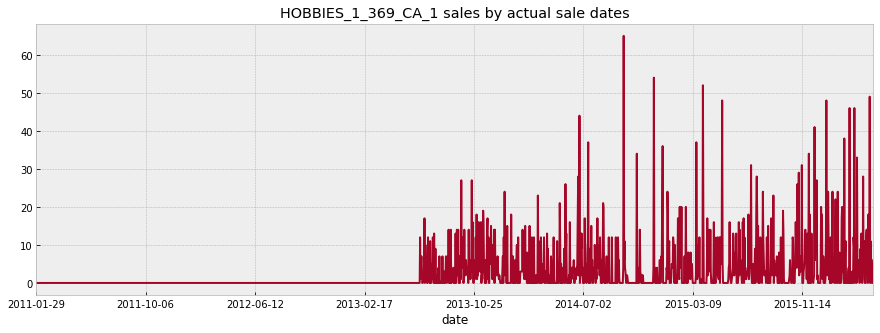

In [9]:
# We can use calendar dates with our item's data

temp1 = sales_TrainVal.loc[sales_TrainVal['id'] == 'HOBBIES_1_369_CA_1_validation'][d_cols].T
temp1 = temp1.rename(columns={360:'HOBBIES_1_369_CA_1'}) 
temp1 = temp1.reset_index().rename(columns={'index': 'd'})
temp1 = temp1.merge(calendar_Dates, how='left', validate='1:1')
temp1.set_index('date')['HOBBIES_1_369_CA_1'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='HOBBIES_1_369_CA_1 sales by actual sale dates')
plt.show()

# We can see now exact dates for the sales

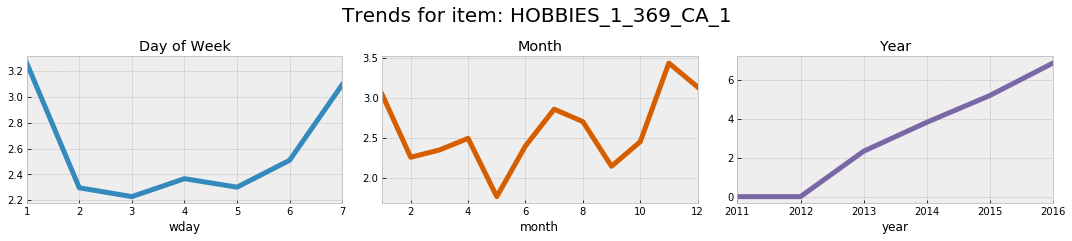

In [10]:
#Let us plot this item for day of the week, month and year

temp2 = 'HOBBIES_1_369_CA_1'

temp_df = temp1

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
temp_df.groupby('wday').mean()[temp2] \
    .plot(kind='line',
          title='Day of Week',
          lw=5,
          color=color_pal[0],
          ax=ax1)
temp_df.groupby('month').mean()[temp2] \
    .plot(kind='line',
          title='Month',
          lw=5,
          color=color_pal[4],

          ax=ax2)
temp_df.groupby('year').mean()[temp2] \
    .plot(kind='line',
          lw=5,
          title='Year',
          color=color_pal[2],

          ax=ax3)
fig.suptitle(f'Trends for item: {temp2}',
             size=20,
             y=1.1)
plt.tight_layout()

plt.show()


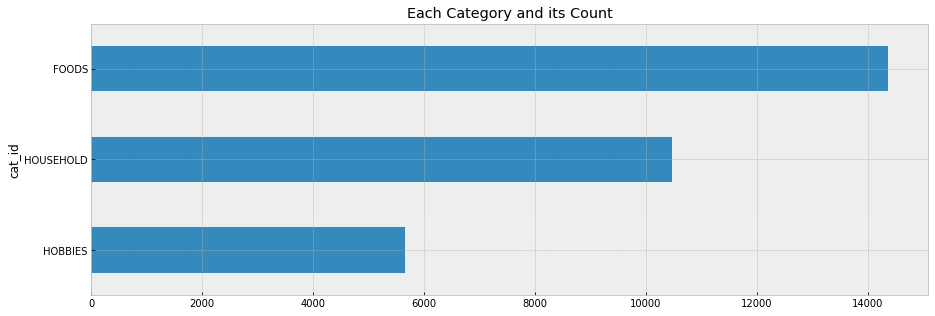

In [12]:
# We can see that there are three categories in items i-e Hobbies, Household and Foods

# Let us plot how many items of each of these catergories are there in data 


sales_TrainVal.groupby('cat_id').count()['id'] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 5), title='Each Category and its Count')
plt.show()


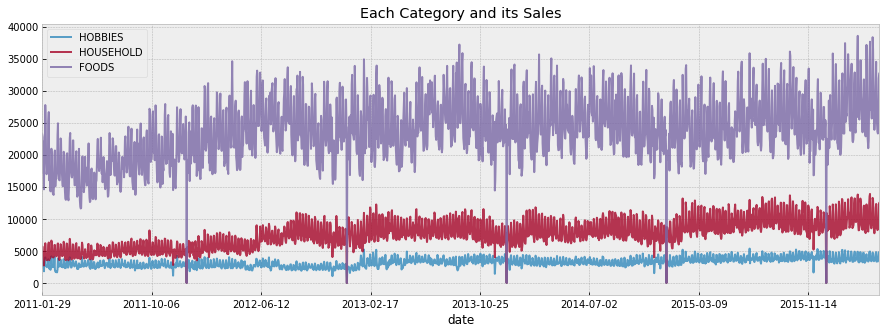

In [14]:
# Let us also plot sales data for each category 

prevSales = sales_TrainVal.set_index('id')[d_cols] \
    .T \
    .merge(calendar_Dates.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')


for i in sales_TrainVal['cat_id'].unique():
    items_col = [j for j in prevSales.columns if i in j]
    prevSales[items_col] \
        .sum(axis=1) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Each Category and its Sales')
plt.legend(sales_TrainVal['cat_id'].unique())

plt.show()

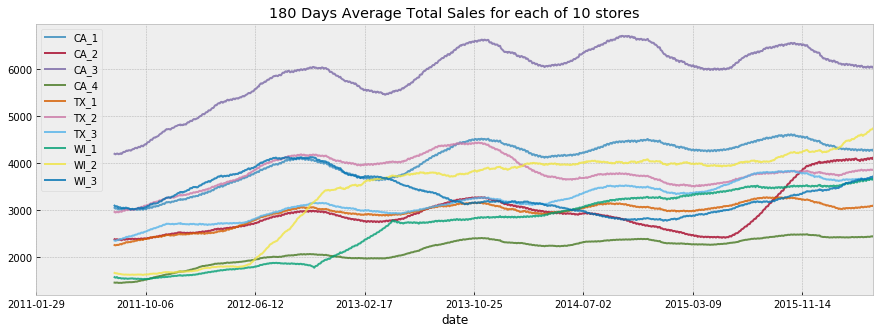

In [18]:
# We have given records of 10 different stores

# Let us plot sales for each of these stores

storesList = selling_P['store_id'].unique()
for store in storesList:
    items_Store = [item for item in prevSales.columns if store in item]
    prevSales[items_Store] \
        .sum(axis=1) \
        .rolling(180).mean() \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='180 Days Average Total Sales for each of 10 stores')
plt.legend(storesList)

plt.show()

In [2]:
calendar_Types = {"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32'}

sellingPrice_Types = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32"}

In [3]:
h = 28
lags_Max = 57
last_Train = 1913
finalDay = datetime(2016,4, 25)

In [ ]:
'''
def create_dt(is_train = True, nrows = None, first_day = 1200):
    prices = pd.read_csv("forecast_walmart_data/sell_prices.csv", dtype = sellingPrice_Types)
    for col, col_dtype in sellingPrice_Types.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
            
    cal = pd.read_csv("forecast_walmart_data/calendar.csv", dtype = calendar_Types)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in calendar_Types.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv("forecast_walmart_data/sales_train_validation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return dt
    
'''

In [4]:
def merge_Cal_Sell(trainFlag = True, rows_Number = None, f_Day = 1200):
    sell_Prices = pd.read_csv("forecast_walmart_data/sell_prices.csv", dtype = sellingPrice_Types)
    for colum, colum_type in sellingPrice_Types.items():
        if colum_type == "category":
            sell_Prices[colum] = sell_Prices[colum].cat.codes.astype("int16")
            sell_Prices[colum] -= sell_Prices[colum].min()
            
    calendarData = pd.read_csv("forecast_walmart_data/calendar.csv", dtype = calendar_Types)
    calendarData["date"] = pd.to_datetime(calendarData["date"])
    for colum, colum_type in calendar_Types.items():
        if colum_type == "category":
            calendarData[colum] = calendarData[colum].cat.codes.astype("int16")
            calendarData[colum] -= calendarData[colum].min()
            
    s_Day = max(1 if trainFlag else last_Train-lags_Max, f_Day)
    colum_Numbers = [f"d_{day}" for day in range(s_Day, last_Train+1)]
    categories_Columns = ['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id']
    type_D = {colum_Number:"float32" for colum_Number in colum_Numbers}
    type_D.update({colum: "category" for colum in categories_Columns if colum != "id"})
    train_Data = pd.read_csv("forecast_walmart_data/sales_train_validation.csv", 
                     nrows = rows_Number, usecols = categories_Columns + colum_Numbers, dtype = type_D)
    
    for colum in categories_Columns:
        if colum != "id":
            train_Data[colum] = train_Data[colum].cat.codes.astype("int16")
            train_Data[colum] -= train_Data[colum].min()
    
    if not trainFlag:
        for day in range(last_Train+1, last_Train+28+1):
            train_Data[f"d{day}"] = np.nan
    
    train_Data = pd.melt(train_Data,
                        id_vars = categories_Columns,
                        value_vars = [colum for colum in train_Data.columns if colum.startswith("d_")],
                        var_name = "d",
                        value_name = "sales")
    train_Data = train_Data.merge(calendarData, on = "d", copy = False)
    train_Data = train_Data.merge(sell_Prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return train_Data

In [6]:
'''

def create_fea(dt):
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

    
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")
            
'''

In [8]:
def feature_Creation(train_Data):
    set_Lags = [7, 28]
    set_Lag_Colum = [f"lag_{l}" for l in set_Lags]
    for l, l_Colum in zip(set_Lags, set_Lag_Colum):
        train_Data[l_Colum] = train_Data[["id", "sales"]].groupby("id")["sales"].shift(l)
        
    set_Win = [7, 28]
    for w in set_Win:
        for l, l_Colum in zip(set_Lags, set_Lag_Colum):
            train_Data[f"rmean_{l}_{w}"] = train_Data[["id", l_Colum]].groupby("id")[l_Colum].transform(lambda z : z.rolling(w).mean())
            
    features_forDate = {
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day"
    }
    
    for date_Name, date_Func in features_forDate.items():
        if date_Name in train_Data.columns:
            train_Data[date_Name] = train_Data[date_Name].astype("int16")
        else:
            train_Data[date_Name] = getattr(train_Data["date"].dt, date_Func).astype("int16")
            
            

In [6]:
%%time

# adding calendar info with selling price data
dataFrame = merge_Cal_Sell(trainFlag=True, f_Day = 350)
dataFrame.shape

Wall time: 1min 38s


In [7]:
dataFrame.head()

id  item_id  dept_id  store_id  cat_id  \
0  HOBBIES_1_002_CA_1_validation        1        0         0       0   
1  HOBBIES_1_004_CA_1_validation        3        0         0       0   
2  HOBBIES_1_005_CA_1_validation        4        0         0       0   
3  HOBBIES_1_008_CA_1_validation        7        0         0       0   
4  HOBBIES_1_009_CA_1_validation        8        0         0       0   

   state_id      d  sales       date  wm_yr_wk  weekday  wday  month  year  \
0         0  d_350    0.0 2012-01-13     11150        0     7      1  2012   
1         0  d_350    2.0 2012-01-13     11150        0     7      1  2012   
2         0  d_350    0.0 2012-01-13     11150        0     7      1  2012   
3         0  d_350    0.0 2012-01-13     11150        0     7      1  2012   
4         0  d_350    2.0 2012-01-13     11150        0     7      1  2012   

   event_name_1  event_type_1  event_name_2  event_type_2  snap_CA  snap_TX  \
0             0             0             0             0      0.0      1.0   
1             0             0             0             0      0.0      1.0   
2             0             0             0             0      0.0      1.0   
3             0             0             0             0      0.0      1.0   
4             0             0             0             0      0.0      1.0   

   snap_WI  sell_price  
0      0.0        3.97  
1      0.0        4.34  
2      0.0        2.48  
3      0.0        0.50  
4      0.0        1.77

In [9]:
%%time

# creating new features to be used in the model such as week, day, rmean and lags
feature_Creation(dataFrame)
dataFrame.shape

Wall time: 5min 23s


In [10]:
dataFrame.head()

id  item_id  dept_id  store_id  cat_id  \
0  HOBBIES_1_002_CA_1_validation        1        0         0       0   
1  HOBBIES_1_004_CA_1_validation        3        0         0       0   
2  HOBBIES_1_005_CA_1_validation        4        0         0       0   
3  HOBBIES_1_008_CA_1_validation        7        0         0       0   
4  HOBBIES_1_009_CA_1_validation        8        0         0       0   

   state_id      d  sales       date  wm_yr_wk  weekday  wday  month  year  \
0         0  d_350    0.0 2012-01-13     11150        0     7      1  2012   
1         0  d_350    2.0 2012-01-13     11150        0     7      1  2012   
2         0  d_350    0.0 2012-01-13     11150        0     7      1  2012   
3         0  d_350    0.0 2012-01-13     11150        0     7      1  2012   
4         0  d_350    2.0 2012-01-13     11150        0     7      1  2012   

   event_name_1  event_type_1  event_name_2  event_type_2  snap_CA  snap_TX  \
0             0             0             0             0      0.0      1.0   
1             0             0             0             0      0.0      1.0   
2             0             0             0             0      0.0      1.0   
3             0             0             0             0      0.0      1.0   
4             0             0             0             0      0.0      1.0   

   snap_WI  sell_price  lag_7  lag_28  rmean_7_7  rmean_28_7  rmean_7_28  \
0      0.0        3.97    NaN     NaN        NaN         NaN         NaN   
1      0.0        4.34    NaN     NaN        NaN         NaN         NaN   
2      0.0        2.48    NaN     NaN        NaN         NaN         NaN   
3      0.0        0.50    NaN     NaN        NaN         NaN         NaN   
4      0.0        1.77    NaN     NaN        NaN         NaN         NaN   

   rmean_28_28  week  quarter  mday  
0          NaN     2        1    13  
1          NaN     2        1    13  
2          NaN     2        1    13  
3          NaN     2        1    13  
4          NaN     2        1    13

In [11]:
dataFrame.dropna(inplace = True)
dataFrame.shape

(39041269, 31)

In [15]:
'''
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]
'''

In [12]:
c_Features = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
other_Columns = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
columns_Training = dataFrame.columns[~dataFrame.columns.isin(other_Columns)]
train_X = dataFrame[columns_Training]
train_Y = dataFrame["sales"]

In [ ]:
'''
%%time

np.random.seed(777)

fake_valid_inds = np.random.choice(X_train.index.values, 2_000_000, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)
train_data = lgb.Dataset(X_train.loc[train_inds] , label = y_train.loc[train_inds], 
                         categorical_feature=cat_feats, free_raw_data=False)
fake_valid_data = lgb.Dataset(train.loc[fake_valid_inds], label = y_train.loc[fake_valid_inds],
                              categorical_feature=cat_feats,
                 free_raw_data=False)# This is a random sample, we're not gonna apply any time series train-test-split tricks here!

In [16]:
%%time

np.random.seed(777)

f_valIndexes = np.random.choice(train_X.index.values, 2_000_000, replace = False)
trainIndexes = np.setdiff1d(train_X.index.values, f_valIndexes)
trainDataFinal = lgb.Dataset(train_X.loc[trainIndexes] , label = train_Y.loc[trainIndexes], 
                         categorical_feature=c_Features, free_raw_data=False)
f_valData = lgb.Dataset(train_X.loc[f_valIndexes], label = train_Y.loc[f_valIndexes],
                              categorical_feature=c_Features,
                 free_raw_data=False)

Wall time: 42.8 s


In [18]:
del dataFrame, train_X, train_Y, f_valIndexes,trainIndexes ; gc.collect()

0

In [20]:
params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.095,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.2,
        "metric": ["rmse"],
        'verbosity': 1,
        'num_iterations' : 1,
        'num_leaves': 90,
        "min_data_in_leaf": 25,
        "early_stopping_round": 1,
}

In [ ]:
%%time

lgb_Model = lgb.train(params, trainDataFinal, valid_sets = [f_valData], verbose_eval=20) 

C:\Users\Syed Zain Raza\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Syed Zain Raza\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Syed Zain Raza\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [ ]:
c

In [20]:
lgb_Model.save_model("model_new.lgb")

In [ ]:
'''

%%time

alphas = [1.028, 1.023, 1.018]
weights = [1/len(alphas)]*len(alphas)
sub = 0.

for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

    te = create_dt(False)
    cols = [f"F{i}" for i in range(1,29)]

    for tdelta in range(0, 28):
        day = fday + timedelta(days=tdelta)
        print(tdelta, day)
        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
        create_fea(tst)
        tst = tst.loc[tst.date == day , train_cols]
        te.loc[te.date == day, "sales"] = alpha*m_lgb.predict(tst) # magic multiplier by kyakovlev



    te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
#     te_sub.loc[te.date >= fday+ timedelta(days=h), "id"] = te_sub.loc[te.date >= fday+timedelta(days=h), 
#                                                                           "id"].str.replace("validation$", "evaluation")
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
    te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    te_sub.fillna(0., inplace = True)
    te_sub.sort_values("id", inplace = True)
    te_sub.reset_index(drop=True, inplace = True)
    te_sub.to_csv(f"submission_{icount}.csv",index=False)
    if icount == 0 :
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols]*weight
    print(icount, alpha, weight)


sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission_newwest.csv",index=False)

'''

In [ ]:
%%time

diffAlphas = [1.033, 1.027, 1.021]

diffWeights = [1/len(diffAlphas)]*len(diffAlphas)

temp = 0

for i, (diffAlpha, diffWeight) in enumerate(zip(diffAlphas, diffWeights)):
    tempTest = merge_Cal_Sell(False)
    colums = [f"F{i}" for i in range(1, 29)]
    
    for tempDelta in range(0, 28):
        d = finalDay + timedelta(days = tempDelta)
        tempTest1 = tempTest[(tempTest.date >= d - timedelta(days = lags_Max)) & (tempTest <= d)].copy()
        feature_Creation(tempTest1)
        tempTest1 = tempTest1.loc[tempTest1.date == day , columns_Training]
        tempTest.loc[tempTest.date == day, "sales"] = diffAlpha*lgb_Model.predict(tempTest1)
        
    tempTest2 = tempTest.loc[tempTest.date >= finalDay, ["id", "sales"]].copy()
    
    tempTest2["F"] = [f"F{rank}" for r in tempTest2.groupby("id")["id"].cumcount()+1]
    tempTest2 = tempTest2.set_index(["id", "F"]).unstack()["sales"][cols].reset_index()
    tempTest2.fillna(0., inplace = True)
    tempTest2.sortvalues("id", inplace = True)
    tempTest2.reset_index(drop = True, inplace = True)
    tempTest2.to_csv(f"submission_{icount}.csv", index = False)
    if i == 0:
        temp = tempTest2
        temp[colums] *= diffWeight 
    else:
        temp[colums] += tempTest2[colums]*diffWeight
        
    
temp2 = temp.copy()
temp2["id"] = temp2["id"].str.replace("validation$", "evaluation")
temp = pd.concat([temp, temp2], axis = 0, sort = False)
temp.to_csv("submission_new.csv", index = False)